In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as transforms
import umap
import sklearn.cluster as cluster

from cryo_sbi import CryoEmSimulator
from cryo_sbi.inference import priors
import cryo_sbi.utils.estimator_utils as est_utils
import cryo_sbi.utils.image_utils as img_utils
import cryo_sbi.utils.micrograph_utils as mic_utils

/home/dingeldein/anaconda3/envs/cryo_sbi/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Setup cell

In [2]:
save_figures = True
test_on_synthetic = False
file_name = "cross_correlation_particles"
path = "../experiments/6wxb/results/nma_results/mixed/"

estimator_config = "../experiments/6wxb/resnet18_fft_encoder.json"
estimator_weights = "../experiments/6wxb/posterior_6wxb_mixed.estimator"
image_config = "image_params_mixed_training.json"

In [3]:
assert os.path.isdir(path), f"Path {path} does not exist"
assert path.endswith("/"), f"Path {path} must end with /"
assert os.path.isfile(estimator_config), f"Estimator config {estimator_config} does not exist"
assert os.path.isfile(image_config), f"Image config {image_config} does not exist"

### Load posterior model

In [4]:
estimator = est_utils.load_estimator(
    estimator_config,
    estimator_weights,
    device="cuda",
)

### Testing posterior on synthetic data

In [5]:
from cryo_sbi.wpa_simulator.noise import correlated_gaussian_noise

In [6]:
if test_on_synthetic:
    cryosbi = CryoEmSimulator(image_config, add_noise=correlated_gaussian_noise)
    indices = torch.tensor(np.arange(0, 100, 5, dtype=float))
    synthetic_images = torch.stack(
        [cryosbi.simulator(index) for index in indices], dim=0
    )
    synthetic_images = img_utils.Mask(128, 60)(synthetic_images)

    samples_syntehtic = est_utils.sample_posterior(
        estimator,
        synthetic_images,
        num_samples=1000,
        batch_size=100,
        device="cuda",
    )

    fig, axes = plt.subplots(4, 5, figsize=(10, 8))
    for idx, ax in enumerate(axes.reshape(-1)):
        ax.imshow(synthetic_images[idx], vmax=4, vmin=-4, cmap="binary")
        ax.set_yticks([])
        ax.set_xticks([])
        ax.text(10, 20, str(int(indices[idx].item())))
    if save_figures:
        fig.savefig(f"{path}{file_name}_synthetic_images.png", dpi=300)

    fig, axes = plt.subplots(4, 5, figsize=(10, 8), sharex=True)
    for idx, ax in enumerate(axes.reshape(1, -1)[0]):
        ax.hist(
            samples_syntehtic[:, idx].flatten().numpy(),
            bins=np.arange(0, 100, 3),
            histtype="step",
            color="blue",
            label="all",
        )
        ax.set_yticks([])
        ax.set_yticks([])
        ax.set_xticks(range(0, 100, 20))
        ax.axvline(indices[idx], color="red")
    if save_figures:
        fig.savefig(f"{path}{file_name}_synthetic_posteriors.png", dpi=300)

### Testing posterior on experimental data

Estimate PSD from experimental data to whiten images

In [7]:
numbers = [1, 7, 8, 9, 10]
paths_to_micrographs = [
    f"../../6wxb/cross_corr/2DTM_{i}/doseweighted.mrc" for i in numbers
]
for path in paths_to_micrographs:
    assert os.path.isfile(path), f"Path {path} does not exist"

In [8]:
micrograph_transform = transforms.Compose(
    [
        img_utils.NormalizeIndividual(),
        img_utils.FourierDownSample(256, 128),
    ]
)

In [9]:
micrographs_patches = mic_utils.RandomMicrographPatches(
    paths_to_micrographs,
    patch_size=256,
    transform=micrograph_transform,
    max_iter=500000,
)

/home/dingeldein/Desktop/cryo_em_SBI/src/cryo_sbi/utils/image_utils.py:227: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:172.)
  return torch.from_numpy(image)


In [10]:
average_psd = mic_utils.compute_average_psd(micrographs_patches, device="cuda")

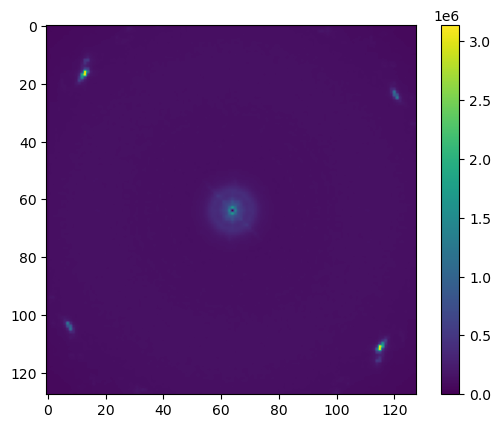

In [11]:
plt.imshow(torch.fft.fftshift(average_psd))
plt.colorbar()
if save_figures:
    plt.savefig(f"{path}{file_name}_average_psd.png", dpi=300)

Load experimental data

In [12]:
transform = transforms.Compose(
    [
        img_utils.MRCtoTensor(),
        img_utils.FourierDownSample(256, 128),
        img_utils.WhitenImage(average_psd),
        img_utils.NormalizeIndividual(),
        img_utils.Mask(128, 60),
    ]
)

In [13]:
"""particles = []
for i in range(1, 70):
    img_file = f"../../6wxb/particles/particles_{i:02d}.mrc"
    tmp_images = transform(img_file)
    particles.append(tmp_images)
particles = torch.cat(particles, dim=0)"""

'particles = []\nfor i in range(1, 70):\n    img_file = f"../../6wxb/particles/particles_{i:02d}.mrc"\n    tmp_images = transform(img_file)\n    particles.append(tmp_images)\nparticles = torch.cat(particles, dim=0)'

In [14]:
img_file = [
    "../../6wxb/cross_corr/2DTM_1/picked-particles.mrc",
    "../../6wxb/cross_corr/2DTM_10/picked-particles.mrc",
    "../../6wxb/cross_corr/2DTM_7/picked-particles.mrc",
    "../../6wxb/cross_corr/2DTM_8/picked-particles.mrc",
    "../../6wxb/cross_corr/2DTM_9/picked-particles.mrc",
]
particles = []

for path in img_file:
    tmp_parts = transform(path)
    particles.append(tmp_parts)
particles = torch.cat(particles, dim=0)

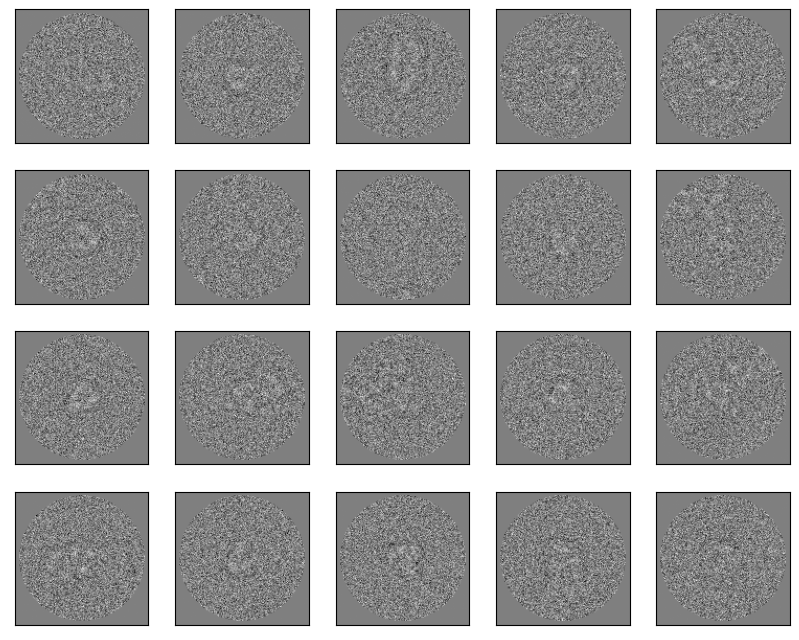

In [29]:
offset = 0
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(particles[i + offset], vmax=4, vmin=-4, cmap="binary")
    ax.set_yticks([])
    ax.set_xticks([])
if save_figures:
    fig.savefig(f"{path}{file_name}_example_particles.png", dpi=300)

In [16]:
samples = est_utils.sample_posterior(
    estimator,
    particles,
    num_samples=10000,
    batch_size=100,
    device="cuda",
)

In [17]:
means = samples.mean(axis=0)
posterior_quantiles = np.quantile(samples.numpy(), [0.025, 1 - 0.025], axis=0)
confidence_widths = (posterior_quantiles[1] - posterior_quantiles[0]).flatten()

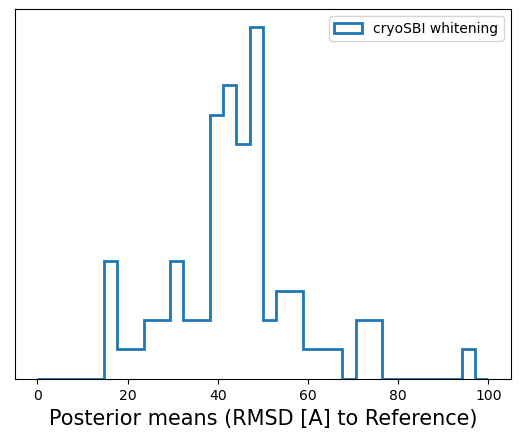

In [18]:
plt.hist(
    means,
    bins=np.linspace(0, 100, 35),
    density=True,
    label="cryoSBI whitening",
    histtype="step",
    linewidth=2,
)

xticks = np.load("../../6wxb/6wxb_nma/nma_files/distance_to_reference_bending_mode.npy")
plt.xlabel("Posterior means (RMSD [A] to Reference)", fontsize=15)
plt.legend()
plt.yticks([])
if save_figures:
    plt.savefig(f"{path}{file_name}_posterior_means.png", dpi=300)

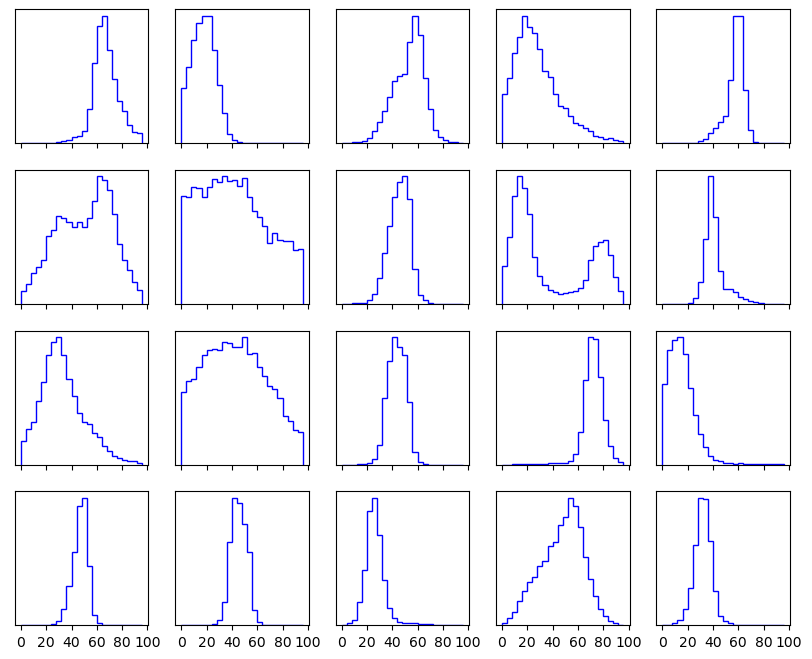

In [19]:
fig, axes = plt.subplots(4, 5, figsize=(10, 8), sharex=True)
for i, ax in enumerate(axes.reshape(1, -1)[0]):
    ax.hist(
        samples[:, i + offset].flatten().numpy(),
        bins=np.arange(0, 100, 4),
        histtype="step",
        color="blue",
    )
    ax.set_yticks([])
    ax.set_yticks([])
    ax.set_xticks(range(0, 101, 20))
if save_figures:
    fig.savefig(
        f"{path}{file_name}_posterior_distributions_example_particles.png", dpi=300
    )

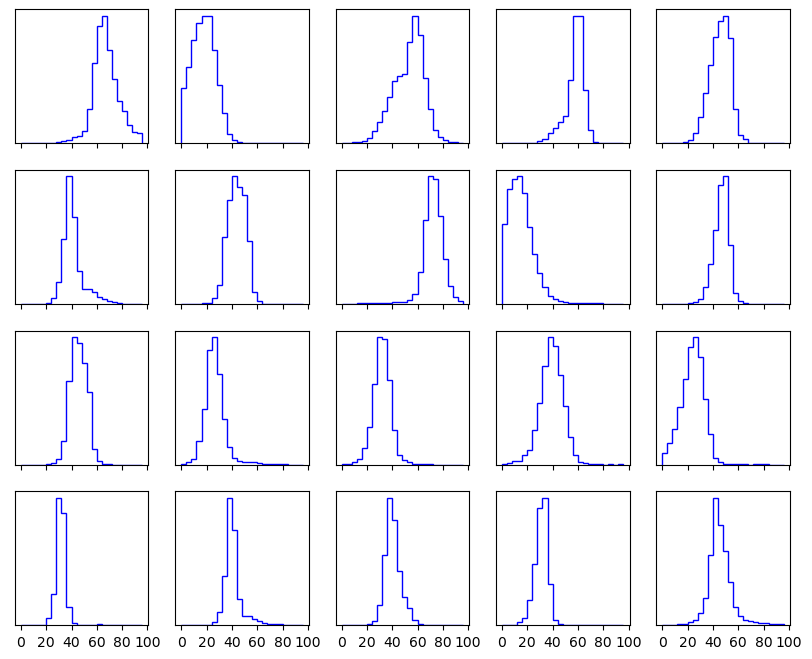

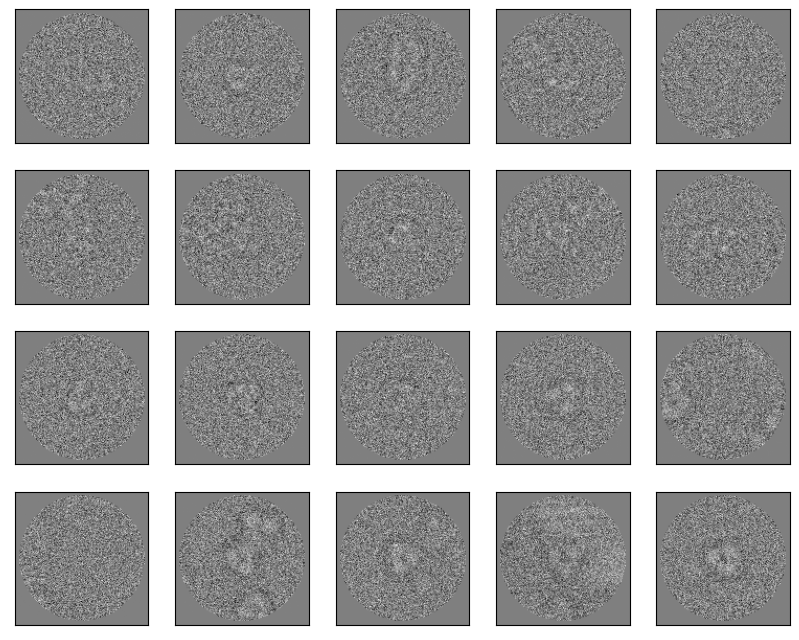

In [20]:
sigma_threshold = 50
idx_high_confidence = np.where(confidence_widths < sigma_threshold)[0]

fig, axes = plt.subplots(4, 5, figsize=(10, 8), sharex=True)
for i, ax in enumerate(axes.reshape(1, -1)[0]):
    ax.hist(
        samples[:, idx_high_confidence[i]].flatten().numpy(),
        bins=np.arange(0, 100, 4),
        histtype="step",
        color="blue",
    )
    ax.set_yticks([])
    ax.set_yticks([])
    ax.set_xticks(range(0, 101, 20))
if save_figures:
    fig.savefig(f"{path}{file_name}_posteriors_3sigma<{sigma_threshold}.png", dpi=300)

fig, axes = plt.subplots(4, 5, figsize=(10, 8))
for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(particles[idx_high_confidence[i]], vmax=4, vmin=-4, cmap="binary")
    ax.set_yticks([])
    ax.set_xticks([])
if save_figures:
    fig.savefig(f"{path}{file_name}_particles_3sigma<{sigma_threshold}.png", dpi=300)

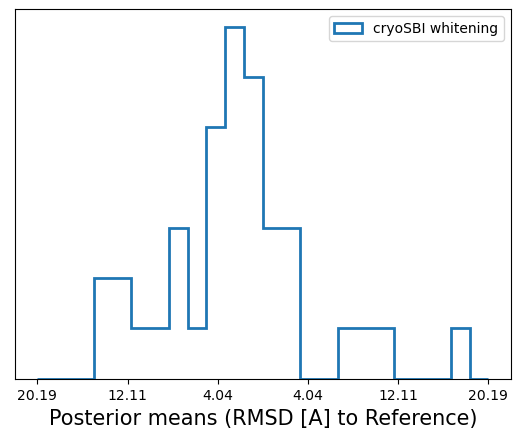

In [21]:
plt.hist(
    means[confidence_widths < sigma_threshold],
    bins=np.linspace(0, 100, 25),
    density=True,
    label="cryoSBI whitening",
    histtype="step",
    linewidth=2,
)

xticks = np.load("../../6wxb/6wxb_nma/nma_files/distance_to_reference_bending_mode.npy")
plt.xlabel("Posterior means (RMSD [A] to Reference)", fontsize=15)
plt.xticks(
    ticks=[0, 20, 40, 60, 80, 100], labels=list(map(lambda x: f"{x:.2f}", xticks[::20]))
)
plt.legend()
plt.yticks([])
if save_figures:
    plt.savefig(
        f"{path}{file_name}_posterior_means_3sigma<{sigma_threshold}.png", dpi=300
    )

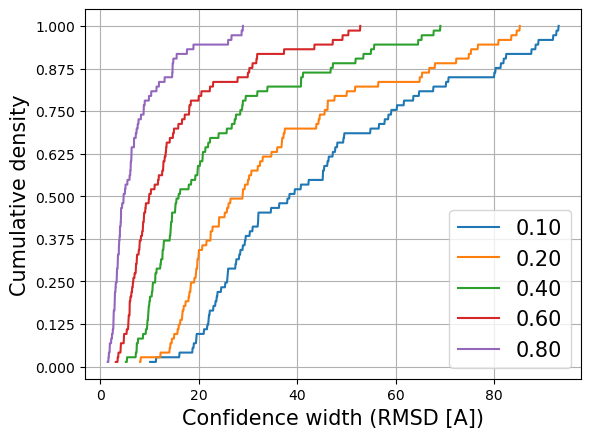

In [22]:
for alpha in [0.05, 0.1, 0.2, 0.3, 0.4]:
    posterior_quantiles = np.quantile(samples.numpy(), [alpha, 1 - alpha], axis=0)
    confidence_widths = (posterior_quantiles[1] - posterior_quantiles[0]).flatten()
    counts, bins = np.histogram(confidence_widths, bins=1000, density=True)
    cum_counts = np.cumsum(counts) / np.sum(counts)
    plt.plot(bins[1:], cum_counts, label=f"{2*alpha:.2f}")

avg_index_to_rmsd = np.mean(np.abs(xticks[1:] - xticks[:-1]))
"""x_tick_pos = np.linspace(0, 100, 9)
x_tick_labels = map(lambda x: f"{x:.2f}", x_tick_pos * avg_index_to_rmsd.item())
plt.xticks(
    ticks=x_tick_pos,
    labels=x_tick_labels,
)"""
plt.yticks(np.linspace(0, 1, 9))
plt.legend(fontsize=15)
plt.grid()
plt.xlabel("Confidence width (RMSD [A])", fontsize=15)
plt.ylabel("Cumulative density", fontsize=15)
if save_figures:
    plt.savefig(f"{path}{file_name}_confidence_widths.png", dpi=300)

Comparing experimental data to synthetic data in latent space using umap

In [103]:
cryosbi = CryoEmSimulator("../experiments/6wxb/image_params_torsion_training.json")
indices = priors.get_uniform_prior_1d(cryosbi.max_index).sample((10000,))
synthetic_images = torch.stack([cryosbi.simulator(index) for index in indices], dim=0)

../data/protein_models/6wxb_torsion_models.npy


In [104]:
synthetic_images_latent = est_utils.compute_latent_repr(
    estimator,
    synthetic_images,
    batch_size=1000,
    device="cuda",
)

In [105]:
particles_latent = est_utils.compute_latent_repr(
    estimator, particles, batch_size=1000, device="cuda"
)

In [106]:
cat_latent_samples = torch.cat((synthetic_images_latent, particles_latent), dim=0)
labels_latent = torch.cat(
    (torch.ones((len(indices),)), torch.zeros((particles.shape[0],))), dim=0
)

In [107]:
reducer = umap.UMAP(metric="euclidean", n_components=2, n_neighbors=1000)
embedding = reducer.fit_transform(cat_latent_samples.numpy())

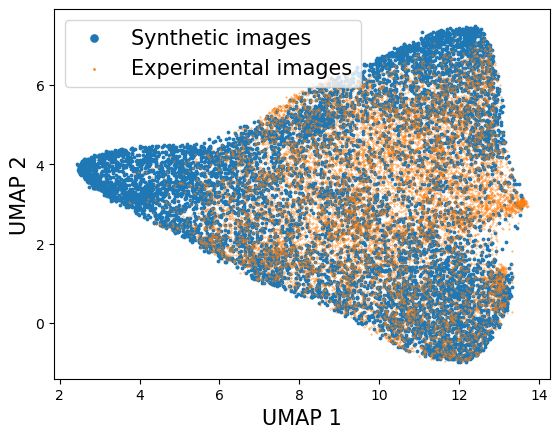

In [108]:
num_syn_parts = len(indices)
plt.scatter(
    embedding[:num_syn_parts, 0],
    embedding[:num_syn_parts, 1],
    s=3,
    label="Synthetic images",
)
plt.scatter(
    embedding[num_syn_parts:, 0],
    embedding[num_syn_parts:, 1],
    s=0.1,
    label="Experimental images",
)
plt.xlabel("UMAP 1", fontsize=15)
plt.ylabel("UMAP 2", fontsize=15)
plt.legend(fontsize=15, markerscale=3, loc="upper left")
if save_figures:
    plt.savefig(f"{path}{file_name}_umap.png", dpi=300)

Exploring latent space with K means clustering

In [23]:
posterior_quantiles = np.quantile(samples.numpy(), [0.025, 1 - 0.025], axis=0)
confidence_widths = (posterior_quantiles[1] - posterior_quantiles[0]).flatten()
means = samples.mean(axis=0).flatten()

In [24]:
particles_latent = est_utils.compute_latent_repr(
    estimator, particles, batch_size=1000, device="cuda"
).numpy()

In [25]:
k_means = cluster.KMeans(n_clusters=5, random_state=0).fit(particles_latent)
cluster_labels = k_means.labels_

/home/dingeldein/anaconda3/envs/cryo_sbi/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


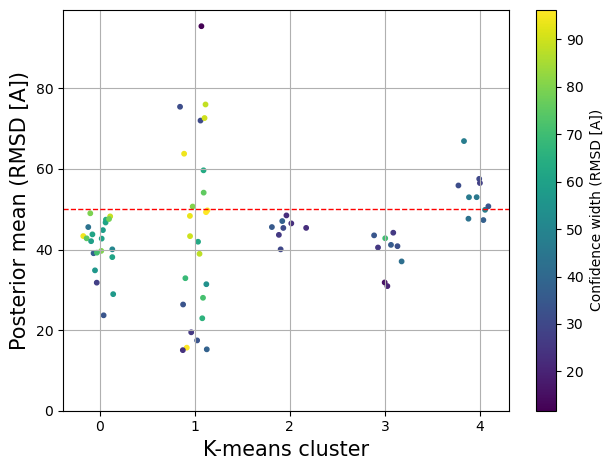

In [26]:
plt.scatter(
    cluster_labels + np.random.normal(0, 0.1, size=cluster_labels.shape),
    means,
    c=confidence_widths,
    s=10,
)
plt.colorbar(label="Confidence width (RMSD [A])")
plt.xlabel("K-means cluster", fontsize=15)
plt.ylabel("Posterior mean (RMSD [A])", fontsize=15)
plt.xticks(np.arange(0, len(set(cluster_labels)), 1))
plt.yticks(np.arange(0, 100, 20))
plt.axhline(50, color="red", linewidth=1, linestyle="--")
plt.grid()
plt.tight_layout()
if save_figures:
    plt.savefig(f"{path}{file_name}_kmeans.png", dpi=300)

In [48]:
np.where(cluster_labels == 2)[0]

array([ 7, 12, 15, 16, 45, 47, 53, 67])

IndexError: index 8 is out of bounds for axis 0 with size 8

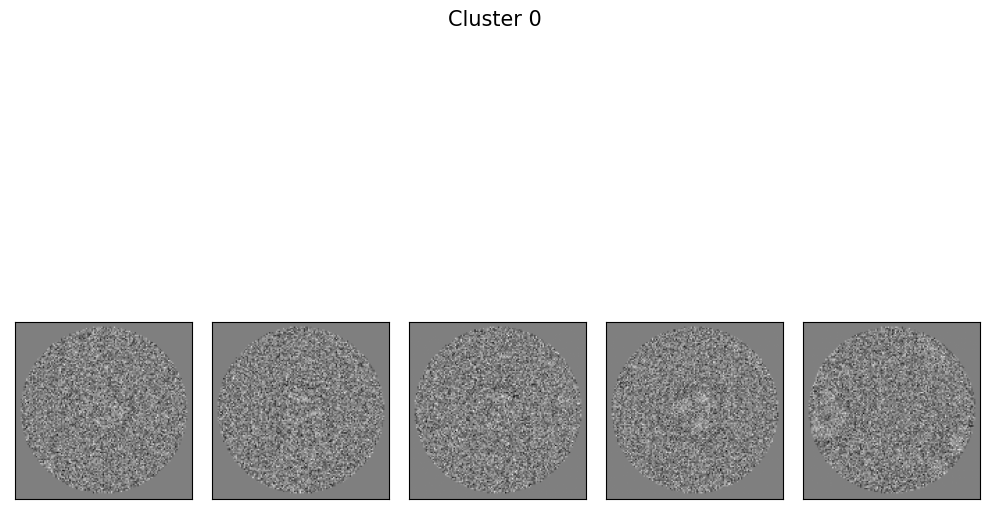

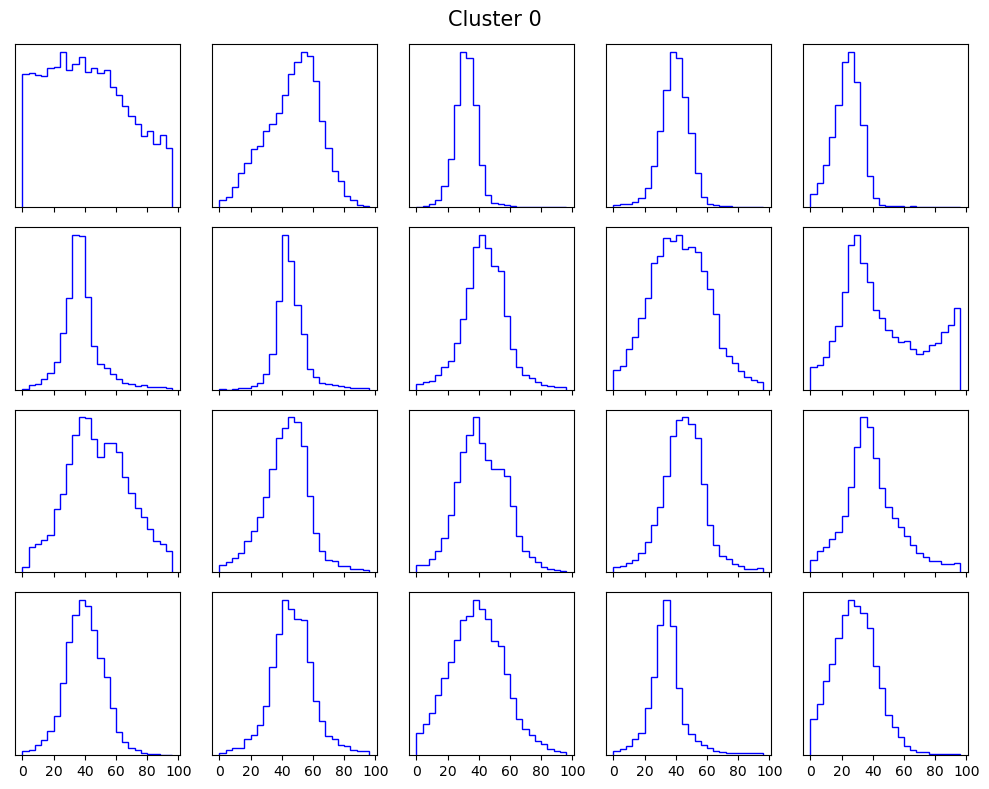

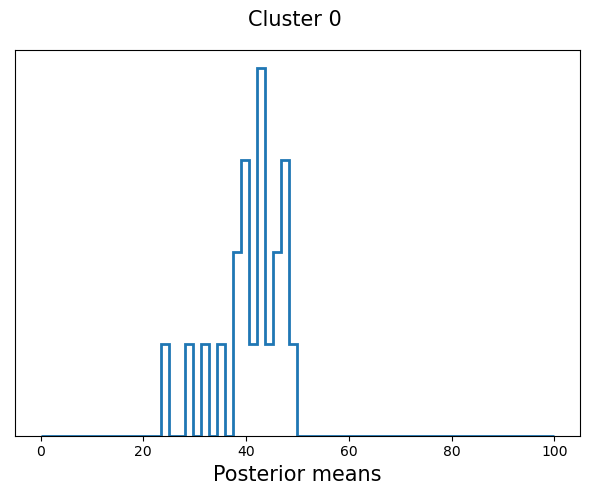

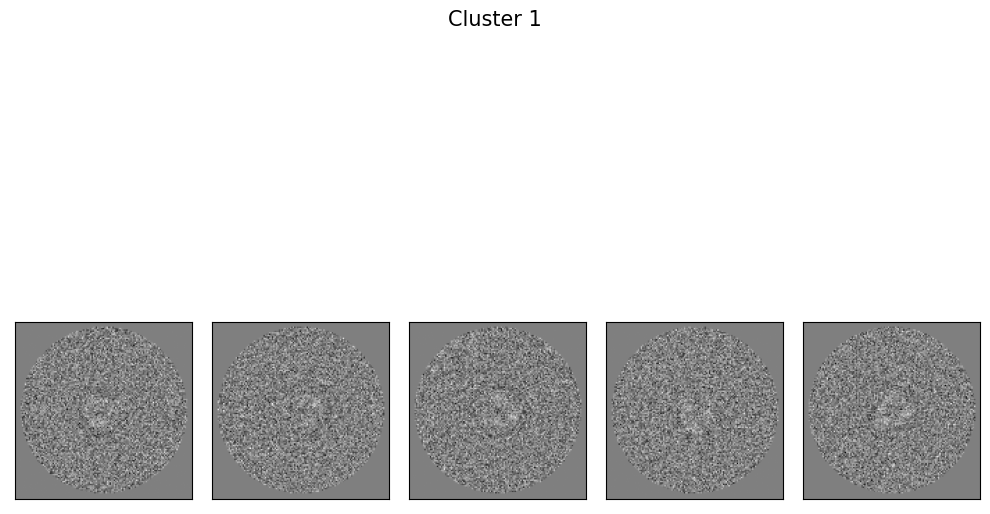

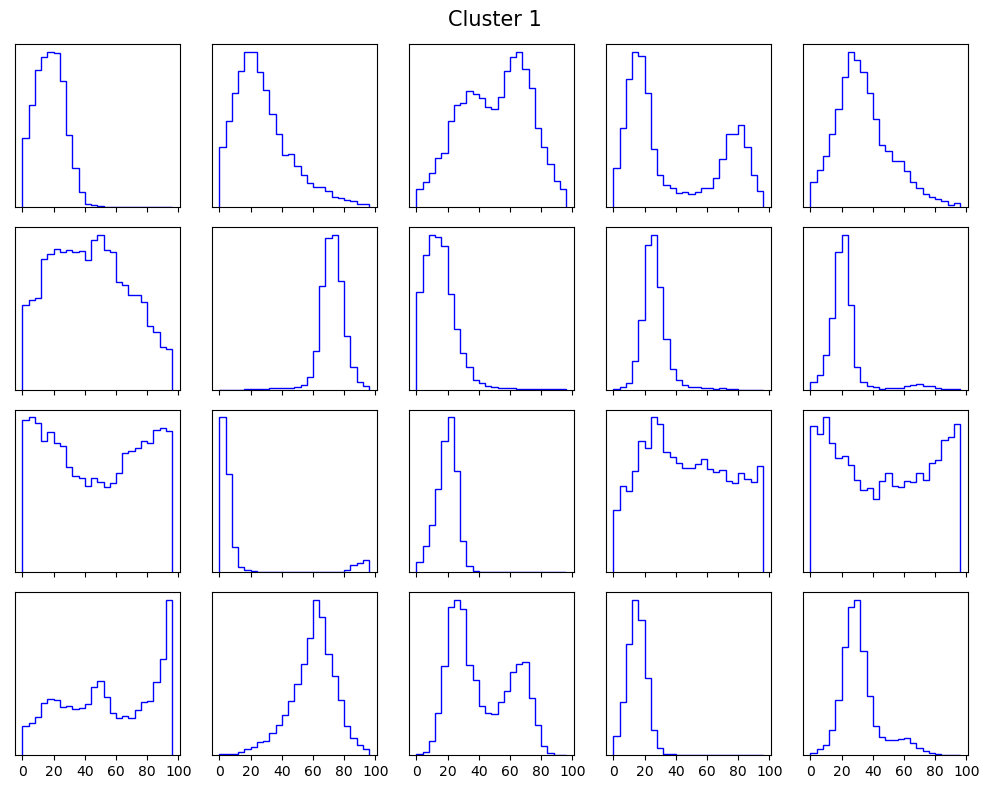

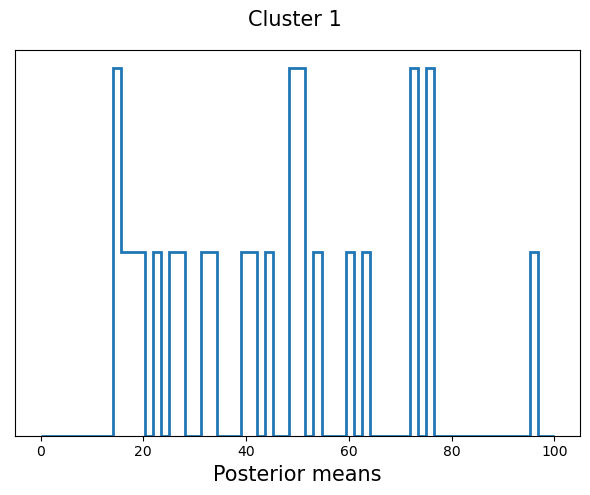

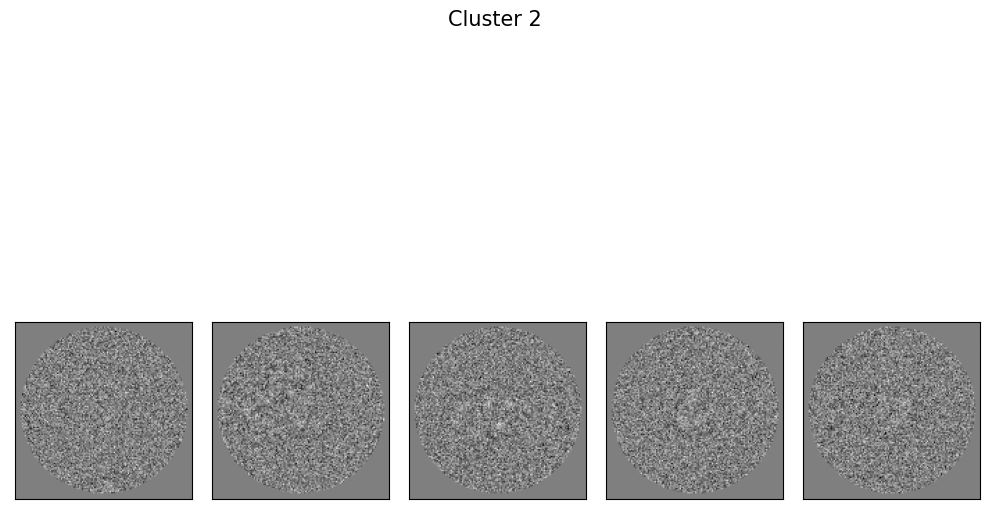

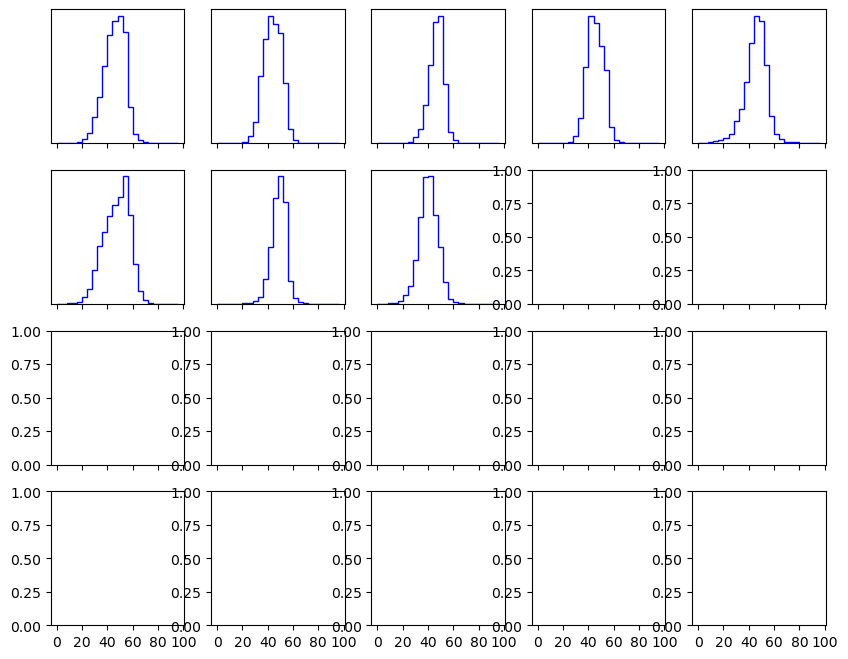

In [49]:
for cluster_label in set(cluster_labels):
    idx = np.where(cluster_labels == cluster_label)[0]

    fig, axes = plt.subplots(1, 5, figsize=(10, 8))
    for i, ax in enumerate(axes.reshape(-1)):
        ax.imshow(particles[idx[i]], vmax=4, vmin=-4, cmap="binary")
        ax.set_yticks([])
        ax.set_xticks([])
    fig.suptitle(f"Cluster {cluster_label}", fontsize=15)
    fig.tight_layout()
    if save_figures:
        fig.savefig(f"{path}{file_name}_cluster_{cluster_label}_particles.png", dpi=300)

    fig, axes = plt.subplots(4, 5, figsize=(10, 8), sharex=True)
    for i, ax in enumerate(axes.reshape(1, -1)[0]):
        ax.hist(
            samples[:, idx[i]].flatten().numpy(),
            bins=np.arange(0, 100, 4),
            histtype="step",
            color="blue",
        )
        ax.set_yticks([])
        ax.set_yticks([])
        ax.set_xticks(range(0, 101, 20))
    fig.suptitle(f"Cluster {cluster_label}", fontsize=15)
    fig.tight_layout()
    if save_figures:
        fig.savefig(
            f"{path}{file_name}_cluster_{cluster_label}_posteriors.png", dpi=300
        )

    fig, axes = plt.subplots(1, 1, figsize=(6, 5))
    _ = axes.hist(
        samples[:, cluster_labels == cluster_label].mean(dim=0),
        bins=np.linspace(0, 100, 65),
        density=True,
        histtype="step",
        linewidth=2,
    )
    axes.set_xlabel("Posterior means", fontsize=15)
    axes.set_yticks([])
    fig.suptitle(f"Cluster {cluster_label}", fontsize=15)
    fig.tight_layout()
    if save_figures:
        fig.savefig(
            f"{path}{file_name}_cluster_{cluster_label}_posterior_means.png", dpi=300
        )